In [121]:
import jax.numpy as jnp
import jax.random as jrandom

import matplotlib.pyplot as plt
import pandas as pd
from jax import jit, grad, jacfwd, jacrev



from scipy.stats import linregress

from tqdm import tqdm
import pickle

import numpy as np

from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [12,12]
plt.style.use('ggplot')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})

We want to minimize the following 
$$ 
    (tr(\Sigma V^T D V \Sigma))^2
$$
with respect to $V$ with $V$ being an orthogonal matrix.

Differentiating with respect to $V$ we have 

$$
    \nabla_V tr(\Sigma V^T D V \Sigma) \\
    = 4 tr(\Sigma V^T D V \Sigma) D V \Sigma^2.
$$
    
    
Now, we also have the condition that the matrix has to be orthogonal $(V^T V) = I$ which leads to the lagrangian 

$$
    \mathcal{L}(V, \lambda) = tr(\Sigma V^T D V \Sigma)^2 + \sum_{i = 1}^d \sum_{j = 1}^d \lambda_{i, j}(v_i^T v_j - \delta_{ij}).
$$

The gradient of the constraint is $V (\lambda + \lambda^T)$. Notice here that $(\lambda + \lambda^T)$ is symmetric. 

We get from the KKT conditions that 

$$
    4 tr(\Sigma V^T D V \Sigma) D V \Sigma^2 = V (\lambda + \lambda^T) \\
    2 tr(\Sigma V^T D V \Sigma) D V \Sigma^2 V^T D V \Sigma^2 = \frac{1}{2} (\lambda + \lambda^T)
$$
and since the RHS is symmetric we have that 
$$
    V^T D V \Sigma^2 = \Sigma^2 V^T D V
$$

implying that $V^T D V$ commutes with $\Sigma^2$. Diagonalizable matricies which commute are mutually diagonalizable. Hence there exists $P$ orthogonal such that $P^{-1} V^T D V P$ and $P^{-1} \Sigma^2 P$ are diagonal matricies. 

Assume such a $P$ exists then we have that for some diagonal matrix $K$ that
$$ 
    P^{-1} \Sigma^2 P = K \\
    \Sigma^2 P K^{-1} = P \\
    \rightarrow \frac{1}{K_i} \Sigma^2 P_i = P_i \\
    \frac{1}{K_i} \Sigma^2_j P_{ij} = P_{ij}. \\
$$

Since $P$ has to have full rank at least one $P_{ij} \neq 0$. Assume that $P_{i j} \neq 0$ for some $j$ then we have
$$
    K_i = \Sigma^2_j
$$
which immidiately implies that for any other $j$ for which $\Sigma^2_j \neq K_i$ $P_{ij} = 0$. 






In [82]:
dim = 4
D = jnp.diag(jnp.array([-5, -2, -1, 4])) # jnp.diag(jnp.linspace(10, 20, dim))
Sigma = jnp.diag(jnp.linspace(-5, 10, dim))

jrandom_key = jrandom.PRNGKey(0)
jrandom_key, subkey = jrandom.split(jrandom_key)
V = jrandom.normal(subkey, shape=(dim, dim,))

predicted_grad = 2 * jnp.trace(Sigma @ V.T @ D @ V @ Sigma) * 2 * D @ V @ Sigma**2

def g(V):
    def f(V):
        V_mat = V.reshape(dim, dim)
        return jnp.trace(Sigma @ V_mat.T @ D @ V_mat @ Sigma)**2
    
            
    return grad(f)(V.flatten()).reshape(dim, dim)

print(predicted_grad)

g(V)




[[ 7.26288278e+04 -1.56562135e-27  3.91039271e+05 -3.19629680e+05]
 [-7.91358056e+04  2.18442846e-28  7.23305570e+04  1.50587901e+05]
 [ 5.38840305e+04 -1.30266379e-28  1.78060919e+04  1.20892572e+05]
 [ 2.39040600e+05 -2.28706380e-27 -3.23974073e+04  7.95064201e+03]]


DeviceArray([[ 7.26288278e+04, -1.56562135e-27,  3.91039271e+05,
              -3.19629680e+05],
             [-7.91358056e+04,  2.18442846e-28,  7.23305570e+04,
               1.50587901e+05],
             [ 5.38840305e+04, -1.30266379e-28,  1.78060919e+04,
               1.20892572e+05],
             [ 2.39040600e+05, -2.28706380e-27, -3.23974073e+04,
               7.95064201e+03]], dtype=float64)

In [7]:
# jrandom_key, subkey = jrandom.split(jrandom_key)
lmbda = jrandom.normal(subkey, shape=(dim, dim,))

def g_const(V, h):
    res = np.zeros(shape=(dim, dim))
    for i in range(dim):
        for j in range(dim):
            h_add = np.zeros(shape=(dim, dim))
            h_add[i, j] = h
            partial = (jnp.sum(lmbda * ((V + h_add).T @ (V + h_add) - np.eye(dim))) - jnp.sum(lmbda * (V.T @ V - np.eye(dim))))/h
            res[i, j] = partial
            
    return res

predicted_g_const = V @ (lmbda + lmbda.T) 

print(predicted_g_const)
g_const(V, 0.001)


[[ 6.01883334  0.54491334  1.82365967  0.74724186]
 [ 0.98134454  1.85397622 -1.50126257  2.17090589]
 [ 0.88566318 -0.48731944  4.24207644 -1.73082982]
 [-0.73719531  1.60649286 -3.40417193  2.66122907]]


array([[ 6.01915267,  0.54498944,  1.82405111,  0.74723094],
       [ 0.98166387,  1.85405231, -1.50087113,  2.17089497],
       [ 0.8859825 , -0.48724334,  4.24246788, -1.73084074],
       [-0.73687598,  1.60656895, -3.40378049,  2.66121815]])

In [5]:
def constraint_grad(V, lmbda):
    return V @ (lmbda + lmbda.T)

def obj_grad(D, V, Sigma):
    return 2 * D @ V @ Sigma**2


V = jnp.eye(dim)

print(obj_grad(D, V, Sigma))

[[-10.   0.   0.   0.]
 [  0. -64.   0.   0.]
 [  0.   0. -98.   0.]
 [  0.   0.   0. 800.]]


In [427]:
def orthog_linesearch(l, c1, c2):

    def helper(X, search_direction, A):
        f0 = l(X)
        g_tau_0 = -1/2 * jnp.linalg.norm(A, "fro")**2
        
        def armijo_rule(alpha):
            return (l(search_direction(alpha)) > f0 + c1*alpha*g_tau_0) # and alpha > 0.001
        
        def armijo_update(alpha):
            return c2*alpha
            
        alpha = 1
        while armijo_rule(alpha):
            alpha = armijo_update(alpha)


        return alpha

    return helper


def optimize_V(D, sing_vals, num_iter, x_init=None):
    """Constraint is V.c = \bar{c} 1 and V.V^T = I"""
    
    dim = D.shape[0]
        
    # init X
    if x_init is None:
        X = jnp.eye(dim)
    else:
        X = x_init
    I = jnp.eye(dim)
    

    
    def l(V):
        V_matrix = V.reshape(dim, dim)
        return jnp.linalg.norm(jnp.diag(sing_vals @ V_matrix.T @ D @ V_matrix @ sing_vals))
    
    
    g_l = grad(l)
    linesearch = orthog_linesearch(l, c1=0.1, c2=0.9)


    eps = 1e-15
    
    l_hist = []
    for _ in tqdm(range(num_iter)):

        num_iter -= 1
        
        G = g_l(X).reshape(dim, dim)
        l_hist.append(l(X))
#         print(jnp.linalg.norm(G))
        
        if jnp.linalg.norm(G) < eps:
            break
        
        A = G @ X.reshape(dim, dim).T - X.reshape(dim, dim) @ G.T
                
        Y = lambda tau: jnp.linalg.inv(I + tau/2 * A) @ (I - tau/2 * A) @ X.reshape(dim, dim)
        
        alpha = linesearch(X, Y, A)
#         print(alpha)
        
        X = Y(alpha)
        
        
    return X, l_hist
        
    



In [428]:
jrandom_key = jrandom.PRNGKey(1)
jrandom_key, subkey = jrandom.split(jrandom_key)

dim = 4


D = jnp.diag(jnp.array([-10, 2, 4, 6]))


x_init = jrandom.normal(subkey, shape=(4, 4))
_, x_init = jnp.linalg.eig(x_init + x_init.T)
x_init = jnp.real(x_init)

sing_vals = jnp.diag(jnp.array([0.3845, 0.31380567, 0.31380567, 0.31380567])) # jnp.diag(jnp.linspace(1, 10, 4))
V, l_hist = optimize_V(D, sing_vals, num_iter=100, x_init=V)

100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


In [411]:
def get_alpha(D, l1, l2):
    Dmax = jnp.max(D)
    Dmin = jnp.min(D)
    return 1/(Dmax - Dmin) * (Dmax + l2/(l1 - l2) * jnp.sum(D))


alpha = get_alpha(jnp.diag(D), l1, l2)
alpha

DeviceArray(0.79895271, dtype=float64)

In [412]:
def create_V(alpha, dim):
    """First column will be the one used"""
    I = jnp.eye(dim)
    v1 = I[0] + alpha * (I[-1] - I[0])
    v1 = jnp.sqrt(v1)
    V_tmp = jnp.concatenate([v1.reshape(1, -1), jnp.eye(dim)[1:]], axis=0)

    V, R = jnp.linalg.qr(V_tmp.T)

    return V

V_pred = create_V(alpha, dim)

In [424]:
jnp.trace(sing_vals @ V.T @ D @ V @ sing_vals)

DeviceArray(0., dtype=float64)

In [ ]:
jnp.trace(sing_vals @ V.T @ D @ V @ sing_vals)

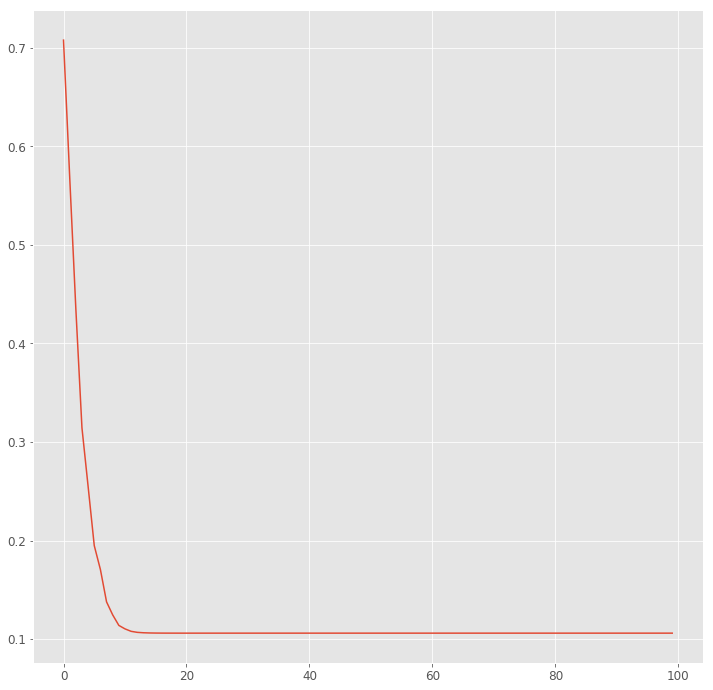

In [429]:
plt.plot(l_hist)

In [386]:
l1, l2 = 0.3845**2, 0.31380567**2

- l2 / (l1 - l2) * jnp.sum(D)


DeviceArray(-7.97905416, dtype=float64)

In [343]:
import sympy
from sympy import symbols, Sum, solve, solve_poly_system, Symbol
from sympy.abc import i, j

dim = 4
a, b, l = symbols("a b l")

D = [1, 2, 3, 4]
sig = 1

# def a_const(a, b, l, D, sig, dim):
#     return sum([D[i] / (a * D[i] / l + b)**0.5 for i in range(1, dim)])  + D[0] * l - a

# def b_const(a, b, l, D, sig, dim):
#     return sum([1 / (a * D[i] / l + b)**0.5 for i in range(1, dim)]) + l - b

def create_a(lmbdas, D, sig, dim):
    return sum([lmbdas[i] * D[i] for i in range(dim)])

def create_b(lmbdas, D, sig, dim):
    return sum(lmbdas)

def li_const(lmbdas, D, sig, dim):
    res = []
    a, b = create_a(lmbdas, D, sig, dim), create_b(lmbdas, D, sig, dim)
    for i in range(1, dim):
        res.append(a * D[i] * lmbdas[i]**2 - lmbdas[0] * sig**2 + lmbdas[0] * lmbdas[i]**2 * b)
        
    return res



def l_const(lmbdas, D, sig, dim):
    a, b = create_a(lmbdas, D, sig, dim), create_b(lmbdas, D, sig, dim)
    return a * D[0] * lmbdas[0] - 1/2 * a**2 * dim - sig**2 * (1 + dim) + b * lmbdas[0]**2



In [285]:
import scipy


In [378]:
def get_alpha(D, l1, l2):
    Dmax = jnp.max(D)
    Dmin = jnp.min(D)
    return 1/(Dmax - Dmin) * (Dmax + l2/(l1 + l2) * jnp.sum(D))



array([3.83704132, 0.15110943, 0.12764754, 0.10178583, 0.09361725,
       0.01006629])

In [221]:
jnp.trace(D @ sing_vals**2)

DeviceArray(-0.00103402, dtype=float64)

In [413]:
jnp.trace(sing_vals @ V.T @ D @ V @ sing_vals)

DeviceArray(-0.14887427, dtype=float64)

In [222]:
jnp.trace(D)

DeviceArray(4, dtype=int64)

In [425]:
jnp.diag(V @ sing_vals**2 @ V.T) @ D

DeviceArray([-1.29295593,  0.196948  ,  0.39389599,  0.70211193], dtype=float64)

In [426]:
D @ V.T**2

DeviceArray([[-6.24345442e+00, -5.11302417e-13, -2.02753493e-08,
              -3.75654556e+00],
             [ 4.68902911e-01,  5.18877844e-01,  2.32830098e-01,
               7.79389147e-01],
             [ 4.19522022e-01,  2.87603270e+00,  7.18186813e-03,
               6.97263408e-01],
             [ 2.17935581e-01,  1.29317416e-01,  5.29073689e+00,
               3.62010112e-01]], dtype=float64)

In [124]:
opt_S = jnp.array([[ 0.18485299,  0.10271554,  0.19002096, -0.17424537],
             [-0.17968624, -0.28818813,  0.05176045, -0.16439829],
             [ 0.01850348, -0.10782008, -0.29744189, -0.22187165],
             [-0.24920671,  0.15387037, -0.0405629 , -0.14929455]])

In [125]:
jnp.linalg.svd(opt_S)

(DeviceArray([[-0.32322302,  0.29401706, -0.78044825,  0.44719277],
              [ 0.61855465, -0.63501181, -0.28772344,  0.36244359],
              [ 0.64851522,  0.52542883, -0.32530302, -0.44444404],
              [ 0.30388325,  0.48398194,  0.44977071,  0.68638383]],            dtype=float64),
 DeviceArray([0.46924893, 0.31380567, 0.31380567, 0.31380567], dtype=float64),
 DeviceArray([[-0.49999999, -0.50000001, -0.49999999, -0.50000001],
              [ 0.18343688,  0.73619347, -0.48729313, -0.43233724],
              [-0.67134978,  0.34108657, -0.26984688,  0.60011006],
              [-0.51540313,  0.30278558,  0.66311996, -0.45050241]],            dtype=float64))

In [122]:
new_V = jnp.array([[-0.32322302,  0.29401706, -0.78044825,  0.44719277],
                   [ 0.61855465, -0.63501181, -0.28772344,  0.36244359],
                   [ 0.64851522,  0.52542883, -0.32530302, -0.44444404],
                   [ 0.30388325,  0.48398194,  0.44977071,  0.68638383]])

In [123]:
new_V.T**2 @ D

DeviceArray([[-1.04473121, -0.38260986,  1.68228796,  0.55407018],
             [-0.86446032, -0.40324   ,  1.10430182,  1.40543111],
             [-6.09099471, -0.08278478,  0.42328822,  1.21376215],
             [-1.99981374, -0.13136536,  0.79012202,  2.82673657]],            dtype=float64)

In [166]:
jnp.trace(new_V.T @ D @ new_V @ sing_vals**2)

DeviceArray(0.21275542, dtype=float64)

In [143]:
def loss_getter(dim, N, H, sig):
    def helper(X):

        S = X.reshape(N, dim).T
        
        S_inv = jnp.linalg.inv(S)
        
        first_term = S_inv.T @ jnp.diag(S.T @ H @ S)
        second_term = jnp.linalg.norm(S_inv, ord="fro")**2
        third_term = S_inv.T @ jnp.ones(dim)
        third_term = jnp.linalg.norm(third_term)**2
        print(jnp.linalg.norm(S)**2)
        return 1/2 * jnp.linalg.norm(first_term)**2 + sig**2 * (second_term + third_term) + jnp.linalg.norm(S)**4

    return helper

In [144]:
l = loss_getter(dim, dim, D, 0.1)
print(l(opt_S.T.flatten()))
grad(l)(opt_S.T.flatten())

0.5156165513454362
0.7975812929443182
Traced<ConcreteArray(0.5156165513454362)>with<JVPTrace(level=2/0)>
  with primal = DeviceArray(0.51561655, dtype=float64)
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=1/0)>


DeviceArray([ 1.69034499e-07, -1.30584488e-08, -1.04445054e-08,
              1.88024357e-07, -2.44826198e-08, -2.53661010e-08,
             -6.77335774e-09,  2.31429744e-08, -2.84264022e-07,
             -7.16226371e-09, -1.36367292e-07, -4.34417252e-08,
              1.21570460e-07,  1.68629482e-08, -6.96805146e-08,
             -4.80161875e-08], dtype=float64)

In [135]:
sig = 0.1

sig**2 * jnp.sum(1/jnp.diag(sing_vals)**2) + 4 * sig**2/jnp.max(jnp.diag(sing_vals))**2 + jnp.max(jnp.diag(sing_vals))**4



DeviceArray(0.58020651, dtype=float64)

In [136]:
jnp.sum(1/jnp.diag(sing_vals)**2)

DeviceArray(35.00633304, dtype=float64)

In [141]:
jnp.max(jnp.diag(sing_vals))

DeviceArray(0.46924893, dtype=float64)

In [142]:
sing_vals

DeviceArray([[0.46924893, 0.        , 0.        , 0.        ],
             [0.        , 0.31380567, 0.        , 0.        ],
             [0.        , 0.        , 0.31380567, 0.        ],
             [0.        , 0.        , 0.        , 0.31380567]],            dtype=float64)

In [145]:
jnp.linalg.svd(opt_S)

(DeviceArray([[-0.32322302,  0.29401706, -0.78044825,  0.44719277],
              [ 0.61855465, -0.63501181, -0.28772344,  0.36244359],
              [ 0.64851522,  0.52542883, -0.32530302, -0.44444404],
              [ 0.30388325,  0.48398194,  0.44977071,  0.68638383]],            dtype=float64),
 DeviceArray([0.46924893, 0.31380567, 0.31380567, 0.31380567], dtype=float64),
 DeviceArray([[-0.49999999, -0.50000001, -0.49999999, -0.50000001],
              [ 0.18343688,  0.73619347, -0.48729313, -0.43233724],
              [-0.67134978,  0.34108657, -0.26984688,  0.60011006],
              [-0.51540313,  0.30278558,  0.66311996, -0.45050241]],            dtype=float64))